<a href="https://colab.research.google.com/github/manas-svg/CFD-of-a-airfoil-wing/blob/main/Wing_parameters_optimizition_using_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ANN model

Saving wing.xlsx to wing.xlsx


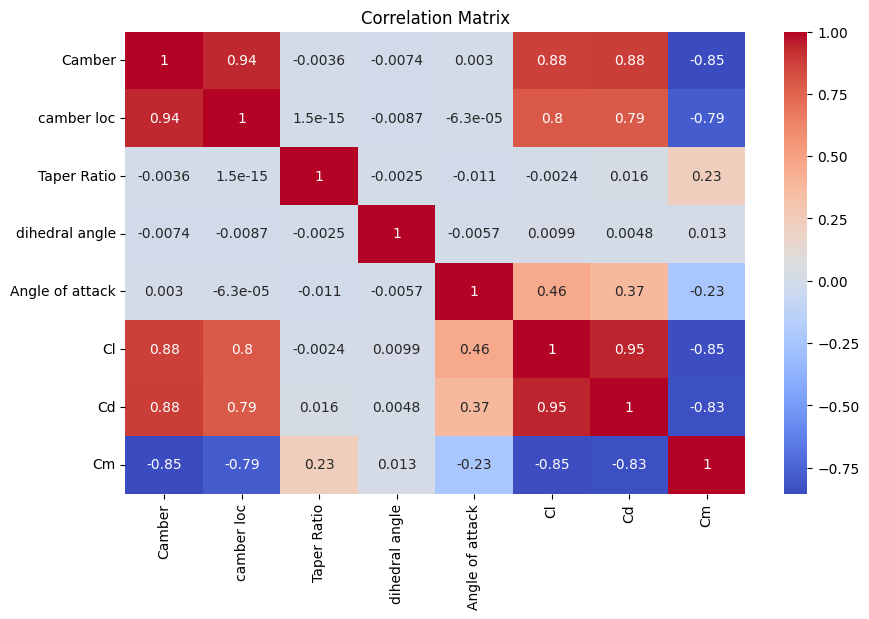

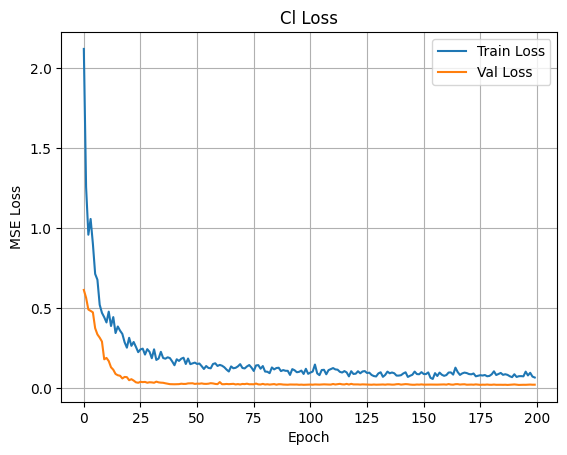

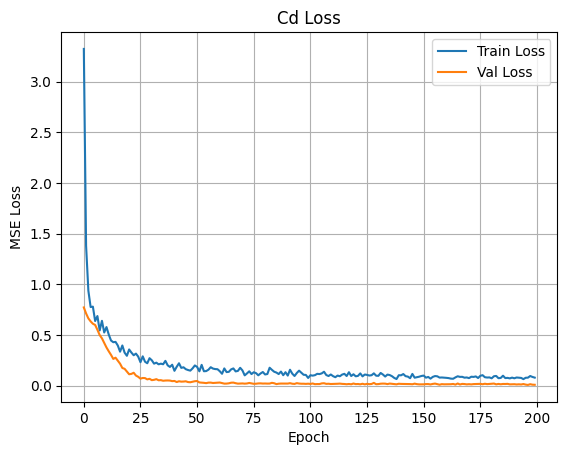

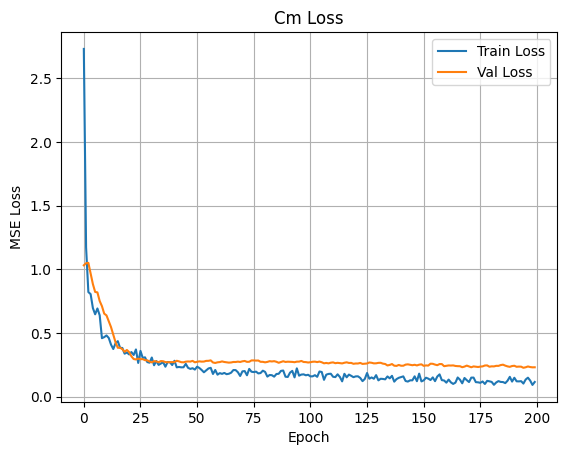

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

📌 Cl Metrics:
  - MSE:  0.0024
  - RMSE: 0.0489
  - MAE:  0.0390
  - R²:   98.18%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0032
  - MAE:  0.0022
  - R²:   98.50%

📌 Cm Metrics:
  - MSE:  0.0143
  - RMSE: 0.1195
  - MAE:  0.0386
  - R²:   85.12%


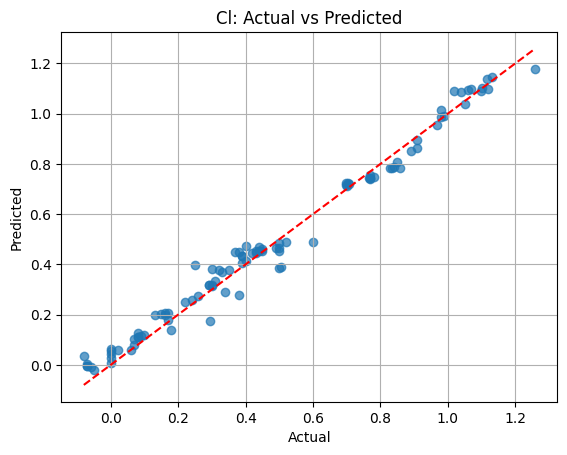

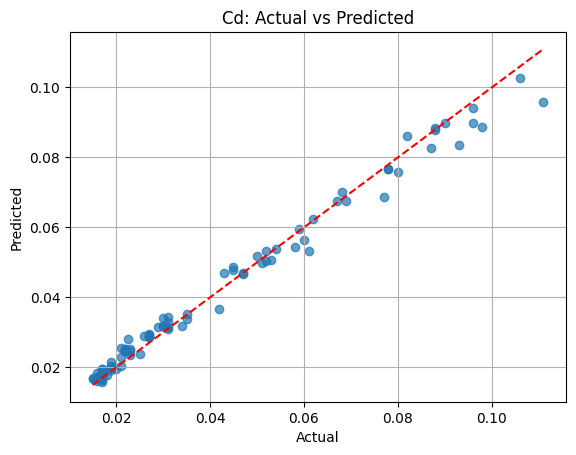

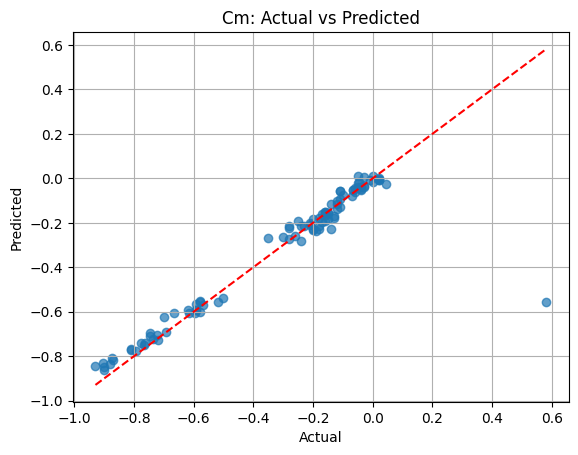

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

🔮 Prediction for New Wing Design:
Cl: 0.9927
Cd: 0.0770
Cm: -0.6254


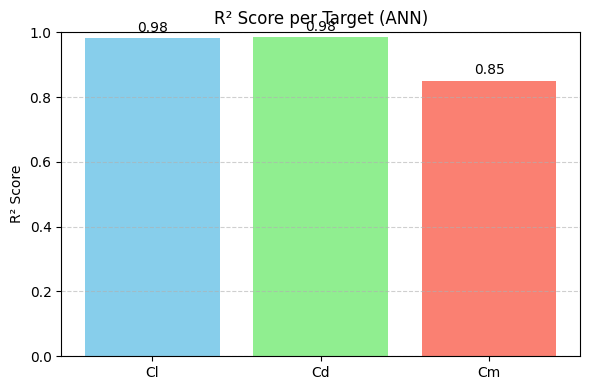

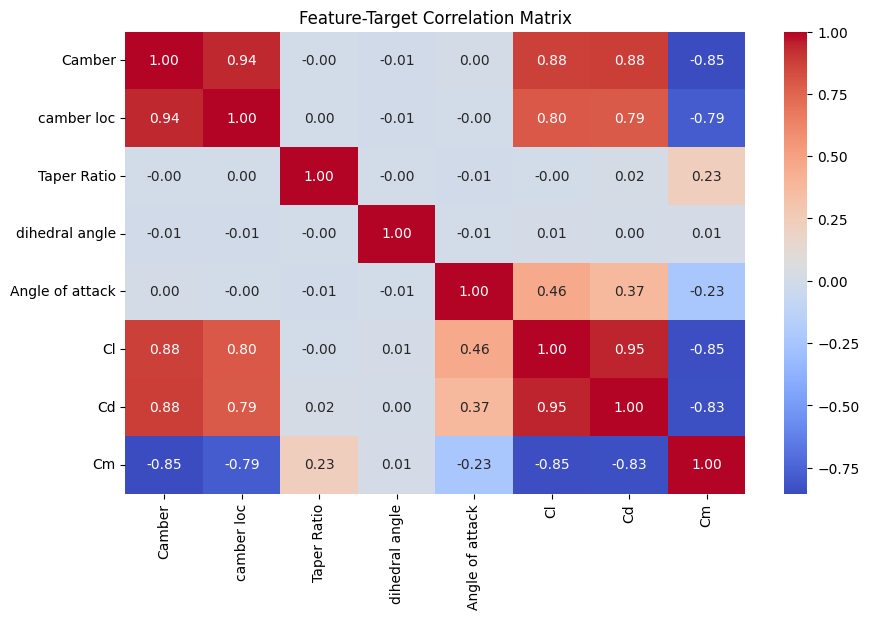

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build ANN Model ===
def build_ann(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

# === Train ANN Models ===
model_cl = build_ann(X_train_pca.shape[1])
model_cd = build_ann(X_train_pca.shape[1])
model_cm = build_ann(X_train_pca.shape[1])

history_cl = model_cl.fit(X_train_pca, y_cl_train_scaled, validation_split=0.2, epochs=200, batch_size=16, verbose=0)
history_cd = model_cd.fit(X_train_pca, y_cd_train_scaled, validation_split=0.2, epochs=200, batch_size=16, verbose=0)
history_cm = model_cm.fit(X_train_pca, y_cm_train_scaled, validation_split=0.2, epochs=200, batch_size=16, verbose=0)

# === Plot Training Loss ===
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_cl, "Cl")
plot_loss(history_cd, "Cd")
plot_loss(history_cm, "Cm")

# === Predictions ===
cl_pred_scaled = model_cl.predict(X_test_pca).ravel()
cd_pred_scaled = model_cd.predict(X_test_pca).ravel()
cm_pred_scaled = model_cm.predict(X_test_pca).ravel()

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(model_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(model_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(model_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (ANN)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

DNN model

Saving wing.xlsx to wing (1).xlsx


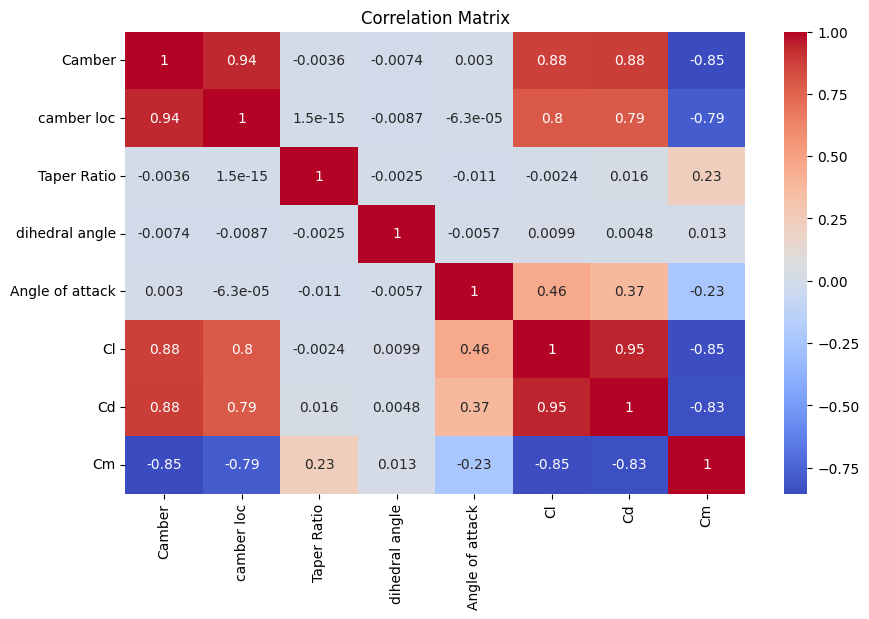

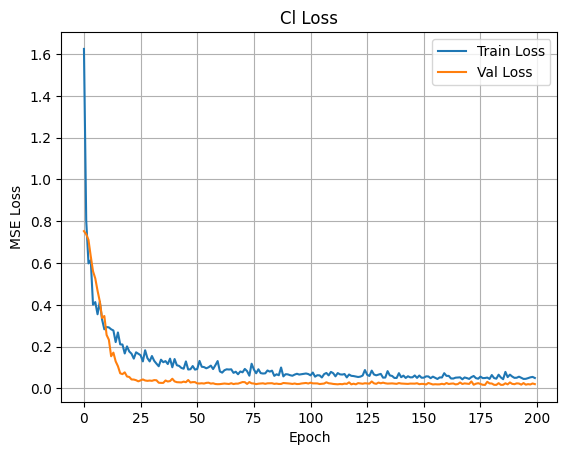

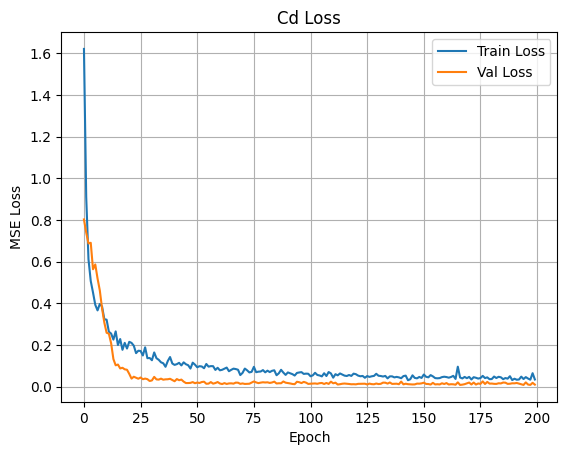

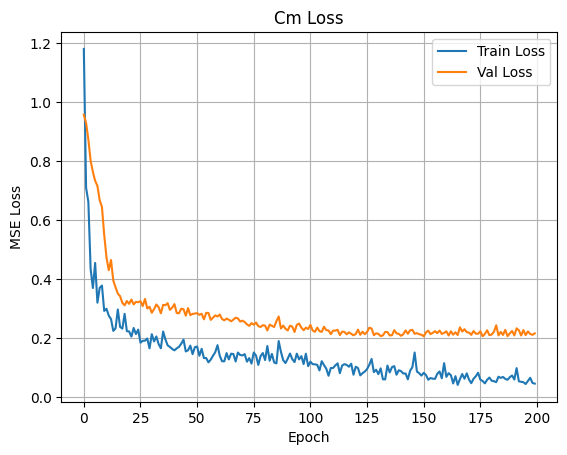

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

📌 Cl Metrics:
  - MSE:  0.0023
  - RMSE: 0.0482
  - MAE:  0.0344
  - R²:   98.23%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0032
  - MAE:  0.0025
  - R²:   98.51%

📌 Cm Metrics:
  - MSE:  0.0146
  - RMSE: 0.1207
  - MAE:  0.0367
  - R²:   84.82%


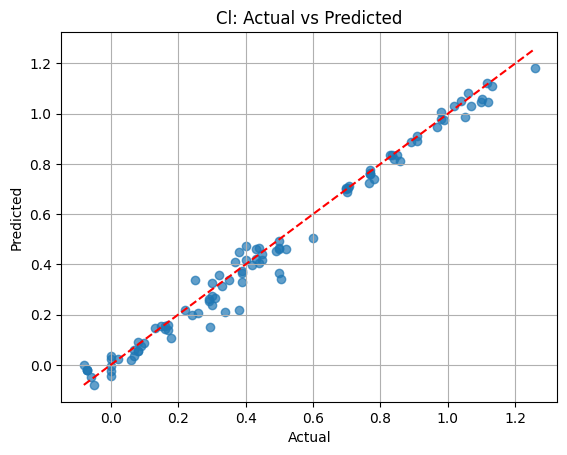

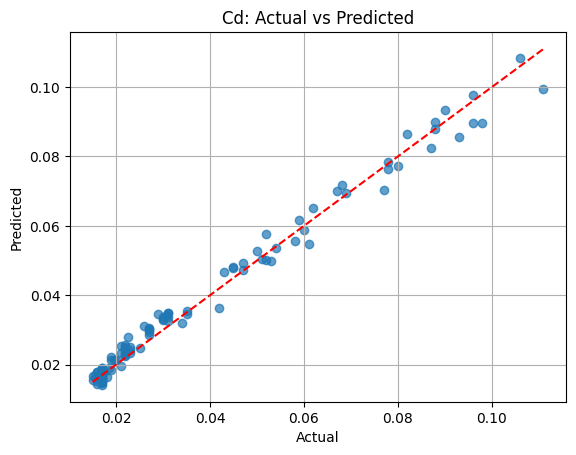

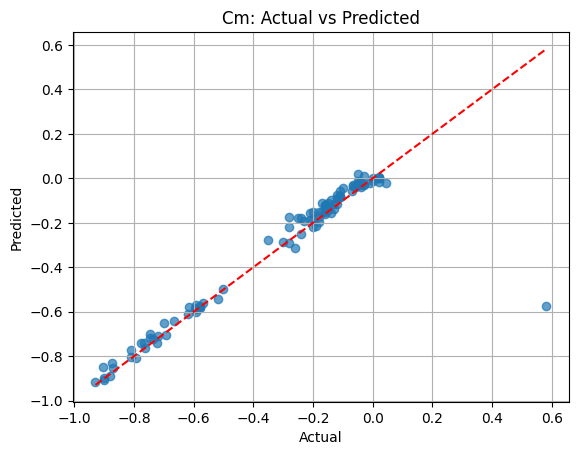

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

🔮 Prediction for New Wing Design:
Cl: 0.9832
Cd: 0.0779
Cm: -0.6475


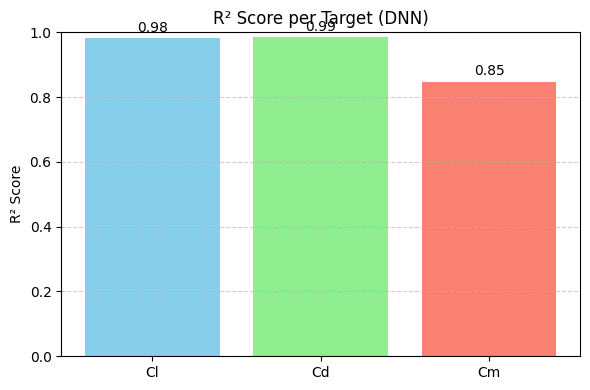

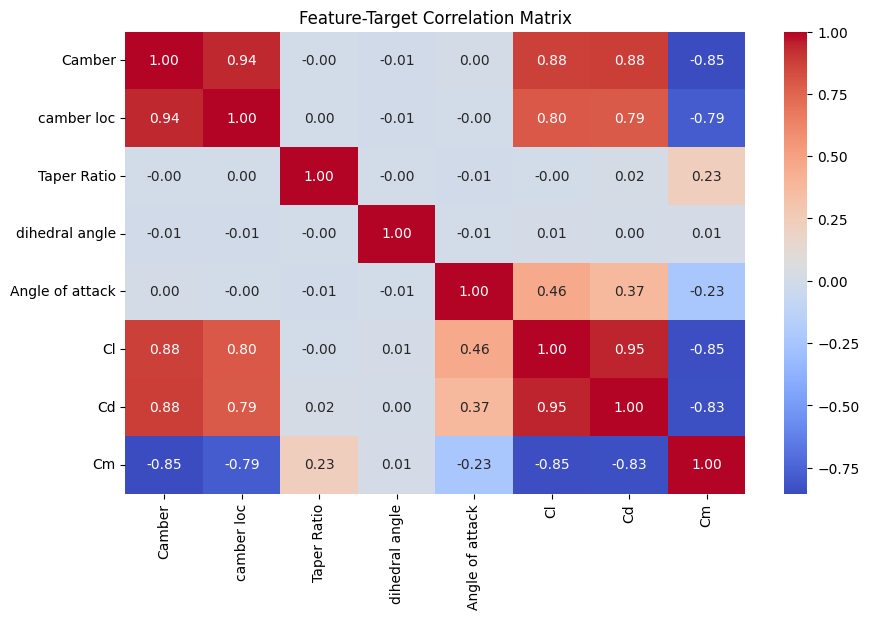

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build Deep Neural Network (DNN) ===
def build_dnn(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

# === Train DNN Models ===
model_cl = build_dnn(X_train_pca.shape[1])
model_cd = build_dnn(X_train_pca.shape[1])
model_cm = build_dnn(X_train_pca.shape[1])

history_cl = model_cl.fit(X_train_pca, y_cl_train_scaled, validation_split=0.2, epochs=200, batch_size=16, verbose=0)
history_cd = model_cd.fit(X_train_pca, y_cd_train_scaled, validation_split=0.2, epochs=200, batch_size=16, verbose=0)
history_cm = model_cm.fit(X_train_pca, y_cm_train_scaled, validation_split=0.2, epochs=200, batch_size=16, verbose=0)

# === Plot Training Loss ===
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_cl, "Cl")
plot_loss(history_cd, "Cd")
plot_loss(history_cm, "Cm")

# === Predictions ===
cl_pred_scaled = model_cl.predict(X_test_pca).ravel()
cd_pred_scaled = model_cd.predict(X_test_pca).ravel()
cm_pred_scaled = model_cm.predict(X_test_pca).ravel()

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(model_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(model_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(model_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (DNN)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

PINN


Saving wing.xlsx to wing (2).xlsx


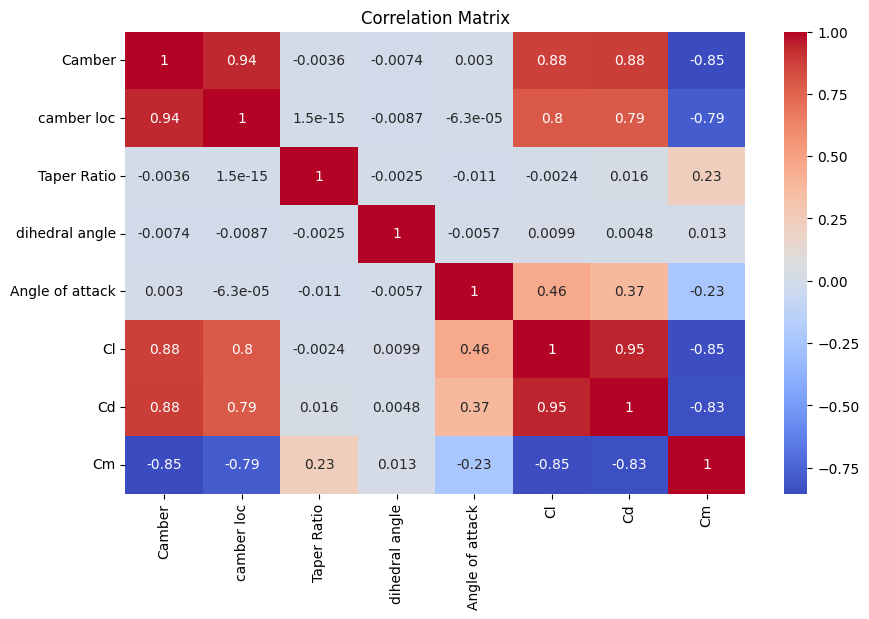

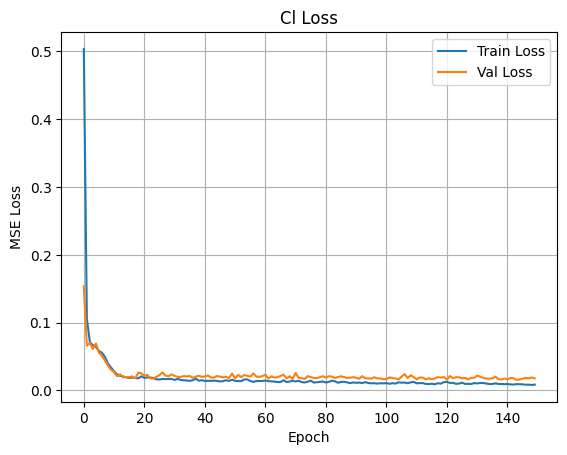

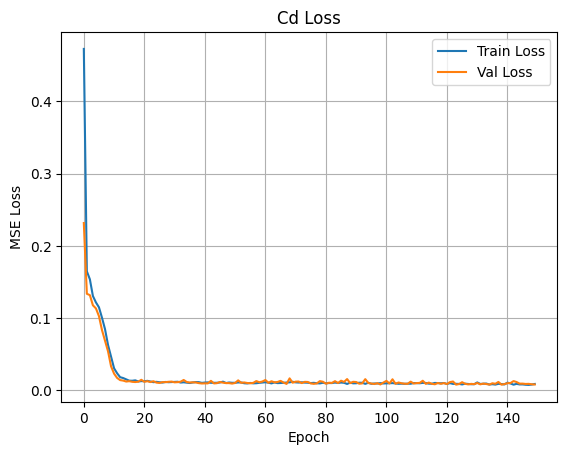

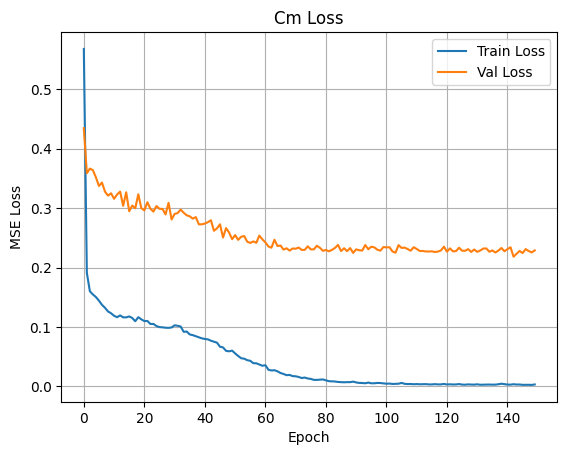

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

📌 Cl Metrics:
  - MSE:  0.0013
  - RMSE: 0.0364
  - MAE:  0.0261
  - R²:   98.99%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0029
  - MAE:  0.0019
  - R²:   98.78%

📌 Cm Metrics:
  - MSE:  0.0156
  - RMSE: 0.1248
  - MAE:  0.0351
  - R²:   83.79%


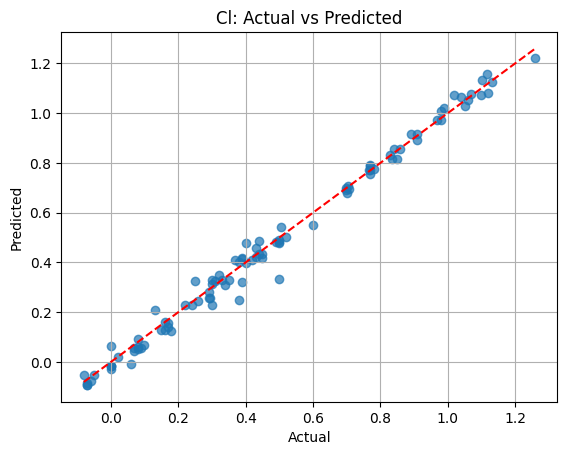

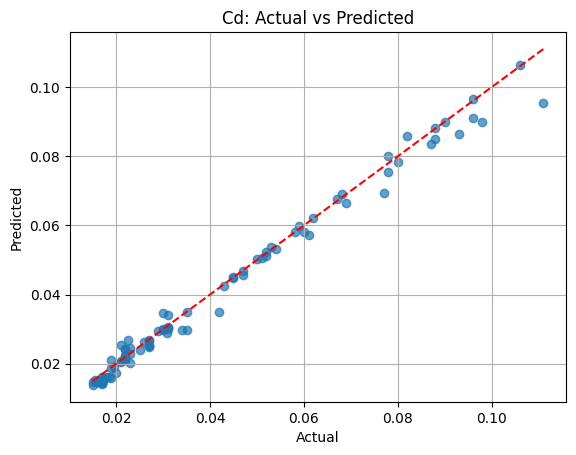

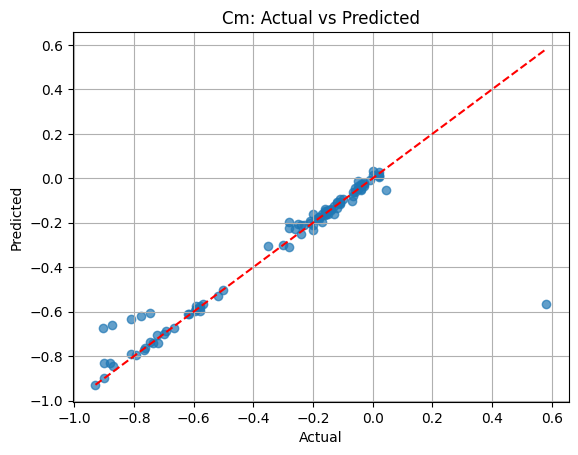

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🔮 Prediction for New Wing Design:
Cl: 1.0127
Cd: 0.0774
Cm: -0.6421


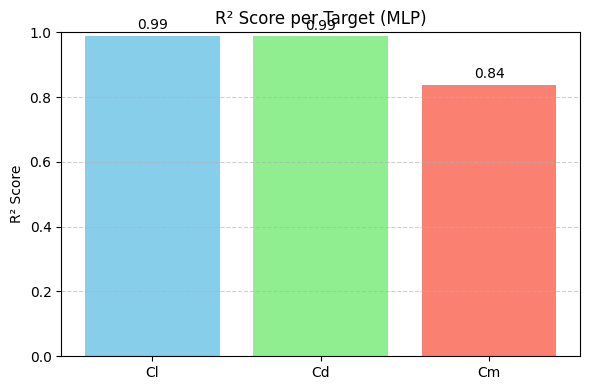

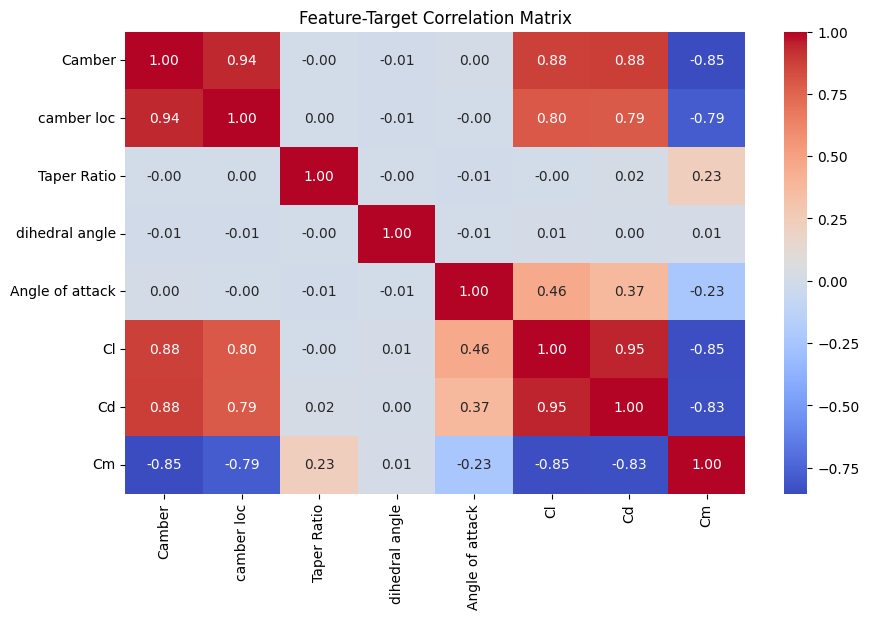

In [ ]:
# Upload the Excel file
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build MLP Model ===
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='tanh')(inputs)
    x = Dense(64, activation='tanh')(x)
    x = Dense(32, activation='tanh')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

# === Train Models ===
model_cl = build_model(X_train_pca.shape[1])
model_cd = build_model(X_train_pca.shape[1])
model_cm = build_model(X_train_pca.shape[1])

history_cl = model_cl.fit(X_train_pca, y_cl_train_scaled, validation_split=0.2, epochs=150, batch_size=16, verbose=0)
history_cd = model_cd.fit(X_train_pca, y_cd_train_scaled, validation_split=0.2, epochs=150, batch_size=16, verbose=0)
history_cm = model_cm.fit(X_train_pca, y_cm_train_scaled, validation_split=0.2, epochs=150, batch_size=16, verbose=0)

# === Plot Training Loss ===
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_cl, "Cl")
plot_loss(history_cd, "Cd")
plot_loss(history_cm, "Cm")

# === Predictions ===
cl_pred_scaled = model_cl.predict(X_test_pca).ravel()
cd_pred_scaled = model_cd.predict(X_test_pca).ravel()
cm_pred_scaled = model_cm.predict(X_test_pca).ravel()

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(model_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(model_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(model_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (MLP)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

ANN+GA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.6 MB/s eta 0:00:00


Saving wing.xlsx to wing (1).xlsx

📌 Cl Metrics:
  - MSE:  0.0096
  - RMSE: 0.0977
  - MAE:  0.0766
  - R²:   92.71%


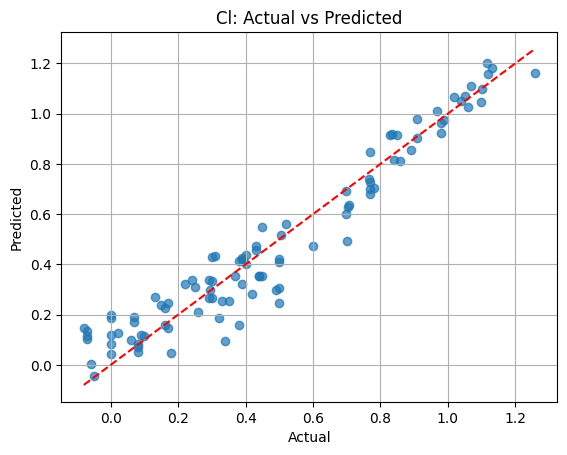


📌 Cd Metrics:
  - MSE:  0.0001
  - RMSE: 0.0110
  - MAE:  0.0089
  - R²:   82.05%


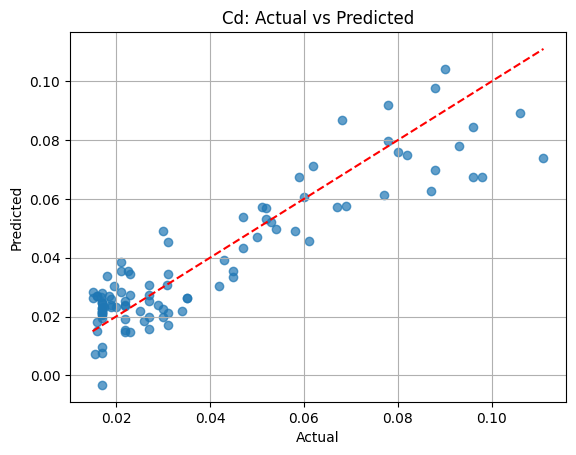


📌 Cm Metrics:
  - MSE:  0.0260
  - RMSE: 0.1612
  - MAE:  0.0900
  - R²:   72.96%


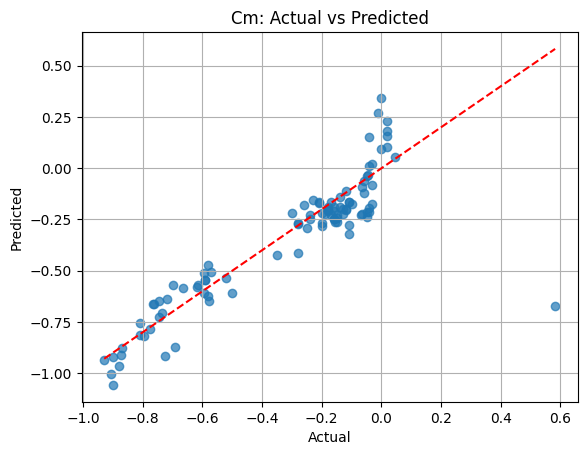

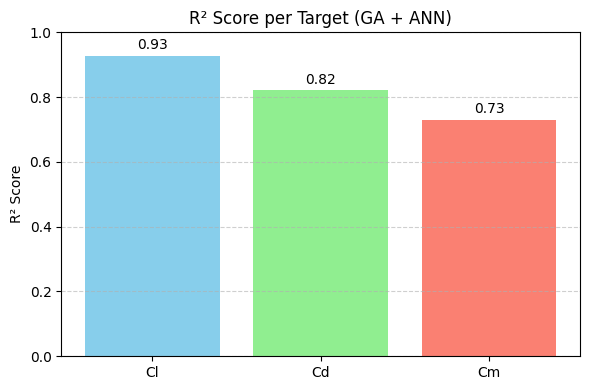

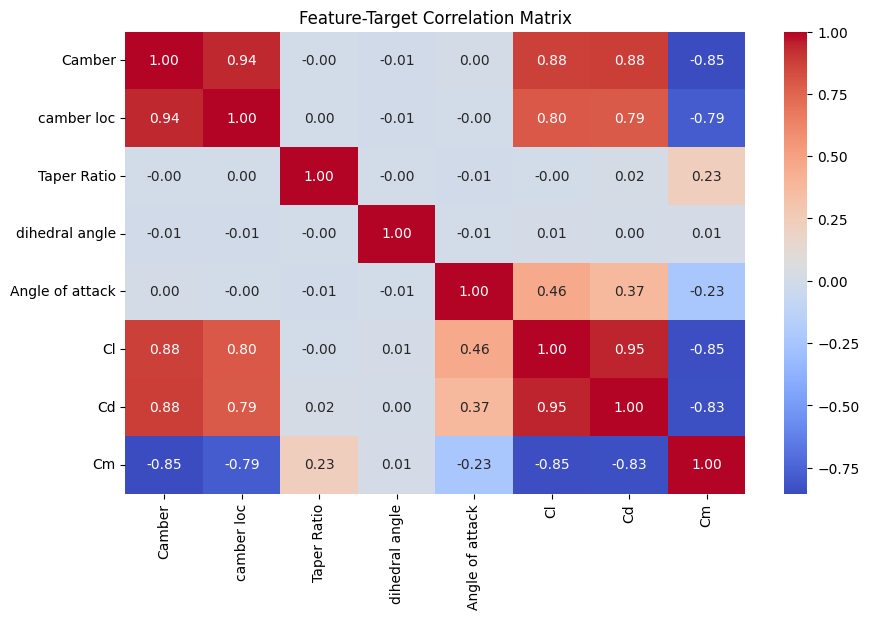


🔮 Prediction for New Wing Design:
Cl: 0.9116
Cd: 0.0677
Cm: -0.7648


In [ ]:
# === Install missing dependencies ===
!pip install deap

# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from deap import base, creator, tools, algorithms
import random
import warnings
warnings.filterwarnings("ignore")

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers from targets
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]

# === Train-Test Split ===
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === GA + ANN Setup ===
def run_ga_ann(y, X_train_scaled, X_test_scaled, label):
    y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

    input_dim = X_train_scaled.shape[1]
    hidden_layers = [10, 10]
    output_dim = 1
    n_weights = (input_dim * hidden_layers[0]) + \
                (hidden_layers[0] * hidden_layers[1]) + \
                (hidden_layers[1] * output_dim) + \
                sum(hidden_layers) + output_dim

    def create_model_from_genome(genome):
        model = Sequential()
        model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
        model.add(Dense(hidden_layers[1], activation='relu'))
        model.add(Dense(output_dim))
        weights = model.get_weights()
        flat_weights = np.concatenate([w.flatten() for w in weights])
        start = 0
        new_weights = []
        for w in weights:
            shape = w.shape
            size = np.prod(shape)
            new_w = np.array(genome[start:start+size]).reshape(shape)
            new_weights.append(new_w)
            start += size
        model.set_weights(new_weights)
        return model

    def evaluate_individual(individual):
        model = create_model_from_genome(individual)
        model.compile(loss='mse', optimizer='adam')
        pred = model.predict(X_train_scaled, verbose=0).ravel()
        return mean_squared_error(y_train_scaled, pred),

    # Avoid multiple DEAP registrations if run more than once
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, -1.0, 1.0)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_weights)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=50)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)

    best_ind = tools.selBest(pop, 1)[0]
    final_model = create_model_from_genome(best_ind)
    final_model.compile(loss='mse', optimizer='adam')

    y_pred_scaled = final_model.predict(X_test_scaled, verbose=0).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")

    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{label}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

    return r2, final_model, scaler_y

# === Run GA+ANN for All Targets ===
r2_scores = []
models = []
scalers_y = []

for target in targets:
    y = df[target]
    r2, model, scaler_y = run_ga_ann(y, X_train_scaled, X_test_scaled, target)
    r2_scores.append(r2)
    models.append(model)
    scalers_y.append(scaler_y)

# === R² Bar Chart ===
plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (GA + ANN)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

# === Predict Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

custom_df = pd.DataFrame([custom_input])
custom_scaled = scaler_X.transform(custom_df)

print("\n🔮 Prediction for New Wing Design:")
for i, target in enumerate(targets):
    pred_scaled = models[i].predict(custom_scaled, verbose=0).reshape(-1, 1)
    pred = scalers_y[i].inverse_transform(pred_scaled)[0][0]
    print(f"{target}: {pred:.4f}")

MLP

Saving wing.xlsx to wing.xlsx


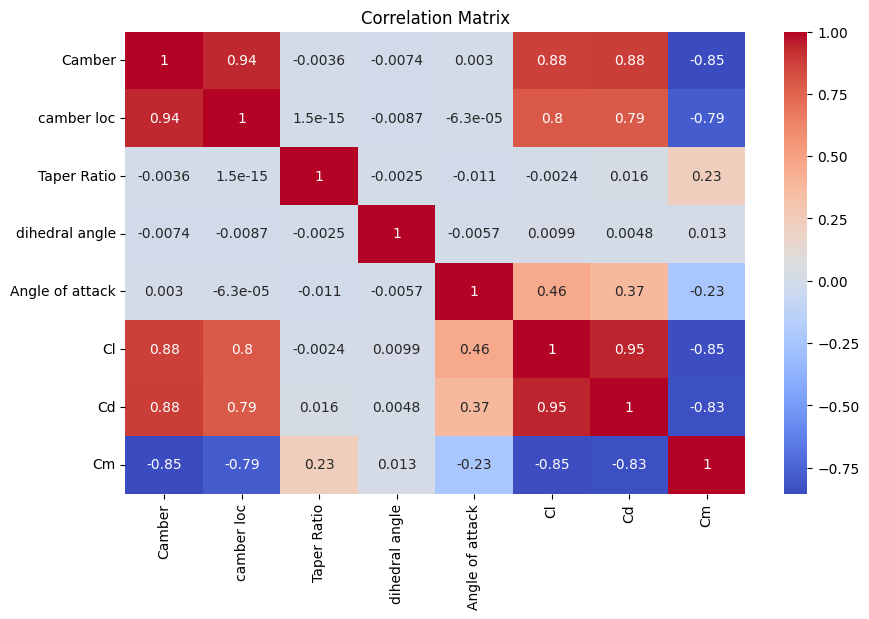


📌 Cl Metrics:
  - MSE:  0.0015
  - RMSE: 0.0393
  - MAE:  0.0247
  - R²:   98.82%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0030
  - MAE:  0.0021
  - R²:   98.64%

📌 Cm Metrics:
  - MSE:  0.0146
  - RMSE: 0.1208
  - MAE:  0.0314
  - R²:   84.82%


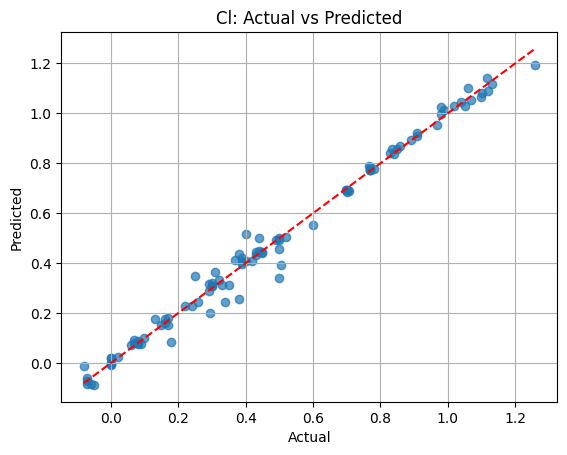

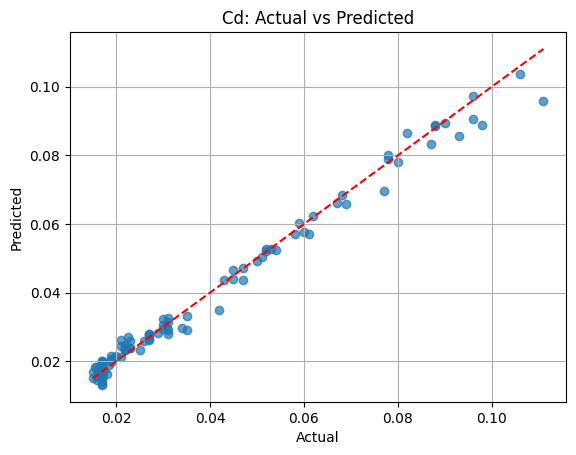

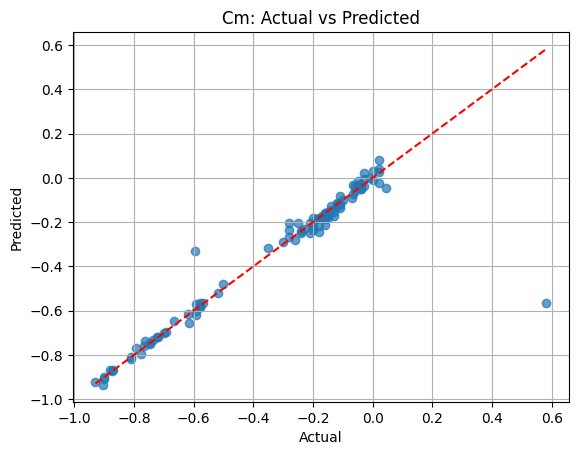


🔮 Prediction for New Wing Design:
Cl: 0.9196
Cd: 0.0731
Cm: -0.6071


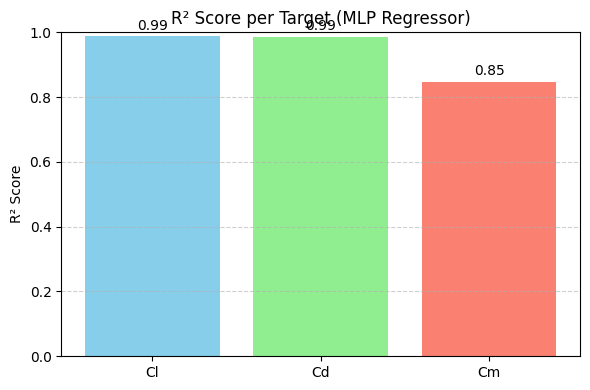

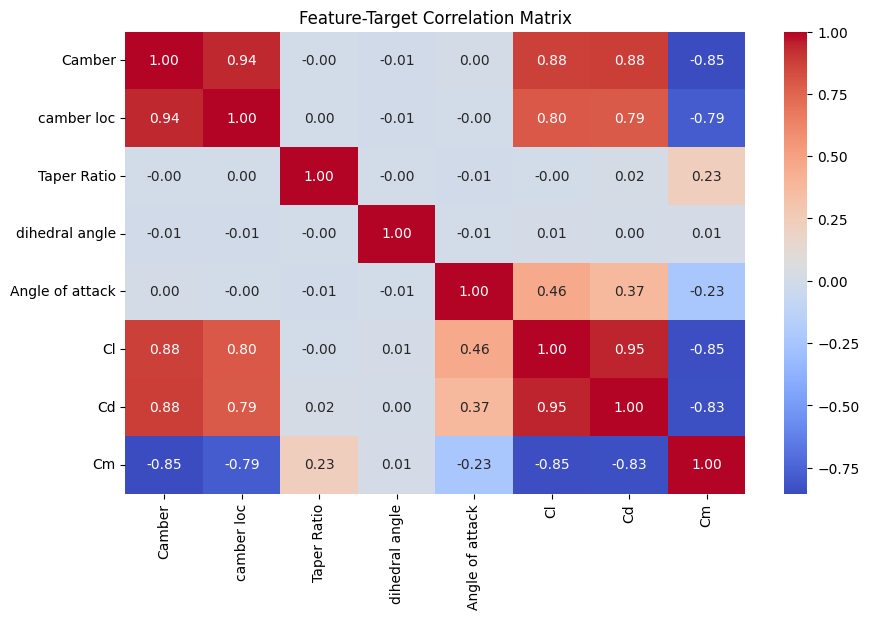

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from scipy.stats import zscore

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build and Train MLP Regressors ===
mlp_cl = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                      max_iter=1000, random_state=42)
mlp_cd = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                      max_iter=1000, random_state=42)
mlp_cm = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam',
                      max_iter=1000, random_state=42)

mlp_cl.fit(X_train_pca, y_cl_train_scaled)
mlp_cd.fit(X_train_pca, y_cd_train_scaled)
mlp_cm.fit(X_train_pca, y_cm_train_scaled)

# === Predictions ===
cl_pred_scaled = mlp_cl.predict(X_test_pca)
cd_pred_scaled = mlp_cd.predict(X_test_pca)
cm_pred_scaled = mlp_cm.predict(X_test_pca)

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(mlp_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(mlp_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(mlp_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (MLP Regressor)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

CAE


Saving wing.xlsx to wing (6).xlsx


Model: "functional_11197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3735 (InputLayer)   │ (None, 5, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 5, 1, 4)        │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 1, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Dense)                 │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11196 (Dense)             │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 5, 1, 1)        │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1.2972 - val_loss: 1.3352
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3113 - val_loss: 1.3167
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.2694 - val_loss: 1.3017
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2326 - val_loss: 1.2897
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2350 - val_loss: 1.2795
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2360 - val_loss: 1.2707
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2377 - val_loss: 1.2638
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1903 - val_loss: 1.2577
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2172 - val_loss: 1.2517
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2313 - val_loss: 1.2461
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1964 - val_loss: 1.2406
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step -

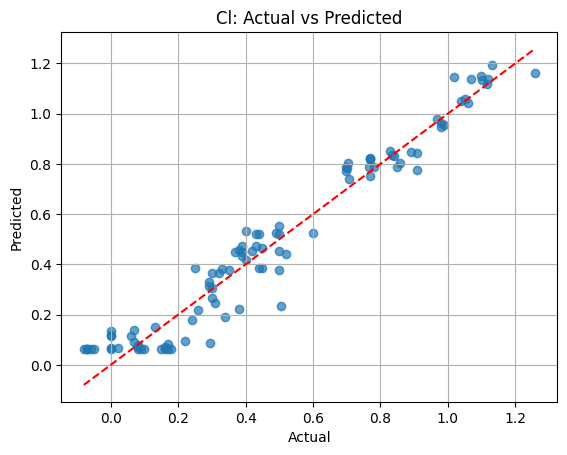

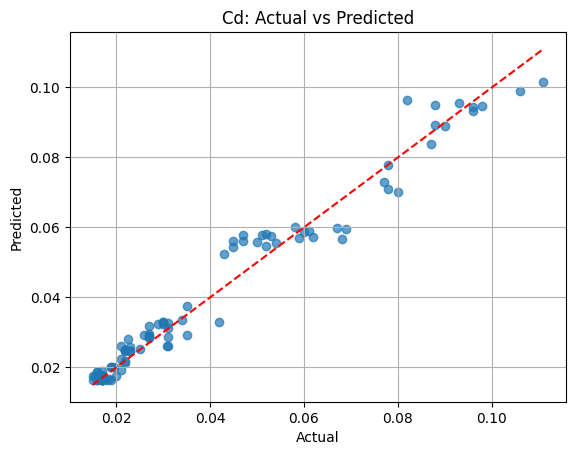

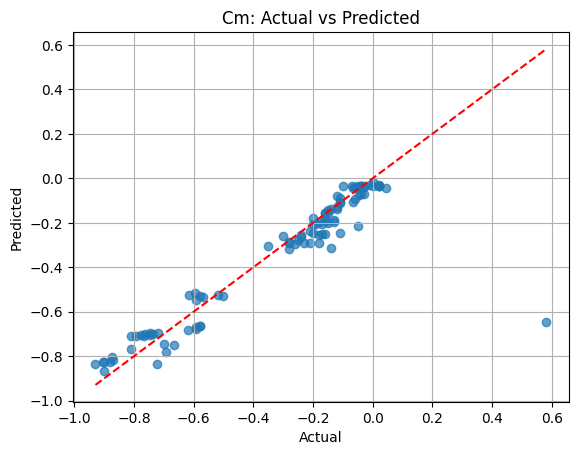

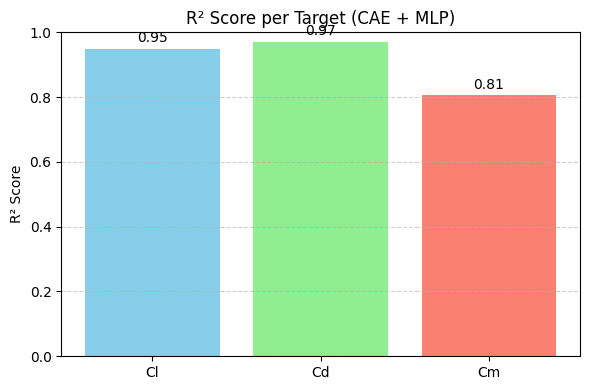

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === Reshape for CAE ===
X_train_reshaped = X_train_scaled.reshape(-1, 5, 1, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 5, 1, 1)

# === Build Convolutional Autoencoder ===
input_layer = Input(shape=(5, 1, 1))

# Encoder
x = Conv2D(4, (2, 1), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 1), padding='same')(x)
x = Flatten()(x)
encoded = Dense(3, activation='relu', name="encoded")(x)

# Decoder
x = Dense(5 * 1 * 1, activation='relu')(encoded)
x = Reshape((5, 1, 1))(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.summary()

# === Train CAE ===
autoencoder.fit(X_train_reshaped, X_train_reshaped, validation_data=(X_test_reshaped, X_test_reshaped),
                epochs=100, batch_size=16, verbose=1)

# === Extract Encoded Features ===
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer("encoded").output)
X_train_encoded = encoder.predict(X_train_reshaped)
X_test_encoded = encoder.predict(X_test_reshaped)

# === Train MLP Regressors ===
mlp_cl = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                      max_iter=1000, random_state=42)
mlp_cd = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                      max_iter=1000, random_state=42)
mlp_cm = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                      max_iter=1000, random_state=42)

mlp_cl.fit(X_train_encoded, y_cl_train_scaled)
mlp_cd.fit(X_train_encoded, y_cd_train_scaled)
mlp_cm.fit(X_train_encoded, y_cm_train_scaled)

# === Predictions ===
cl_pred_scaled = mlp_cl.predict(X_test_encoded)
cd_pred_scaled = mlp_cd.predict(X_test_encoded)
cm_pred_scaled = mlp_cm.predict(X_test_encoded)

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (CAE + MLP)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

SVR

Saving wing.xlsx to wing (7).xlsx


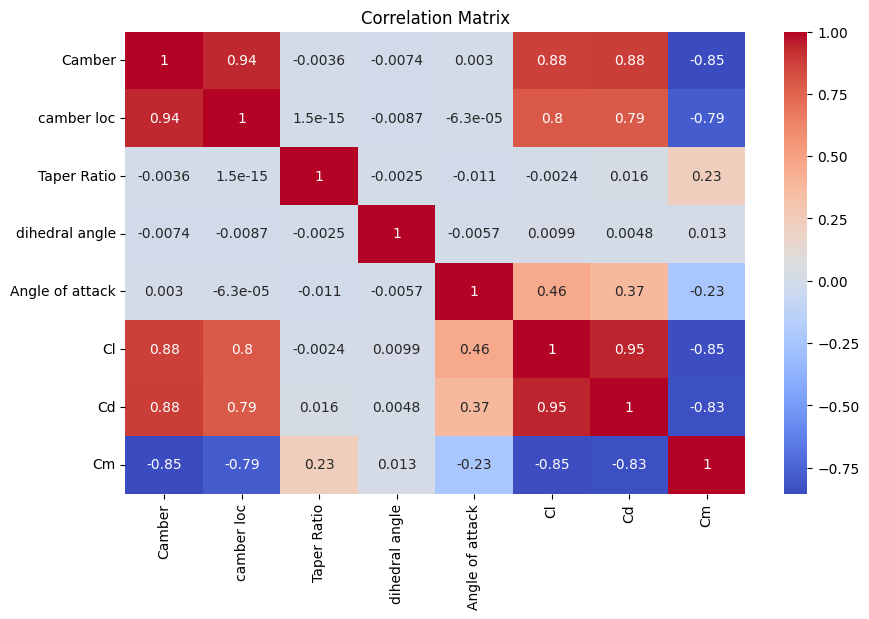


📌 Cl Metrics:
  - MSE:  0.0015
  - RMSE: 0.0389
  - MAE:  0.0304
  - R²:   98.84%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0030
  - MAE:  0.0019
  - R²:   98.69%

📌 Cm Metrics:
  - MSE:  0.0142
  - RMSE: 0.1193
  - MAE:  0.0323
  - R²:   85.18%


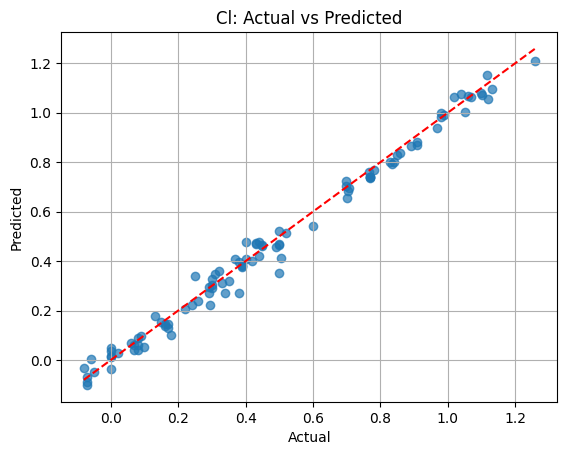

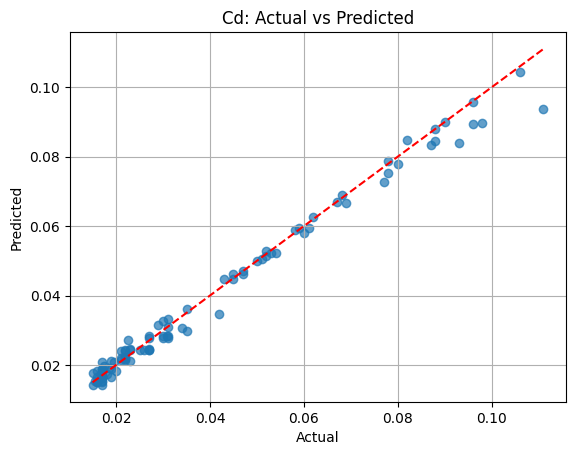

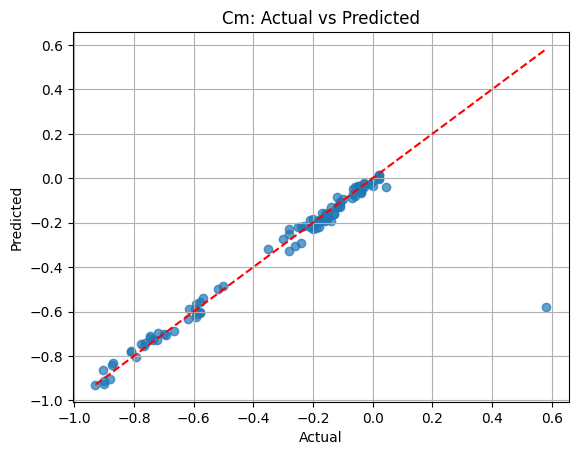


🔮 Prediction for New Wing Design:
Cl: 0.9644
Cd: 0.0749
Cm: -0.6331


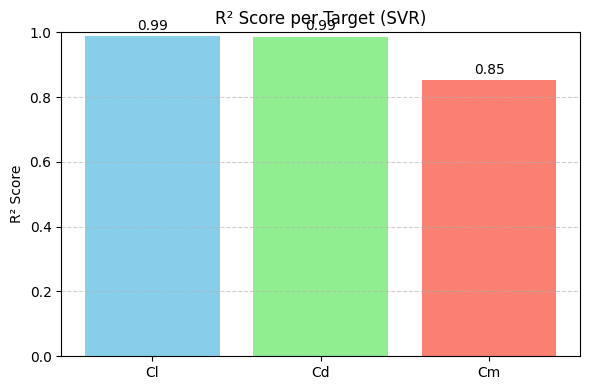

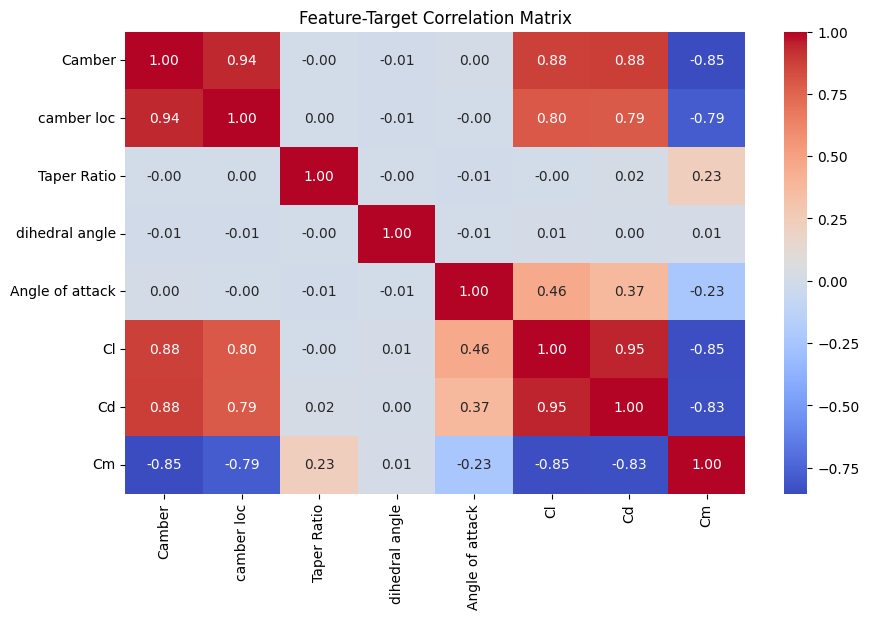

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore
from sklearn.svm import SVR

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove unnamed columns
df.dropna(inplace=True)  # Drop rows with missing values

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]  # Remove rows where any Cl, Cd, or Cm is an outlier

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build SVR Model ===
def build_svr():
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    return svr

# === Train SVR Models ===
svr_cl = build_svr()
svr_cd = build_svr()
svr_cm = build_svr()

svr_cl.fit(X_train_pca, y_cl_train_scaled)
svr_cd.fit(X_train_pca, y_cd_train_scaled)
svr_cm.fit(X_train_pca, y_cm_train_scaled)

# === Predictions ===
cl_pred_scaled = svr_cl.predict(X_test_pca)
cd_pred_scaled = svr_cd.predict(X_test_pca)
cm_pred_scaled = svr_cm.predict(X_test_pca)

# Inverse scaling to get original values
cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(svr_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(svr_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(svr_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (SVR)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

Random forest

Saving wing.xlsx to wing (8).xlsx


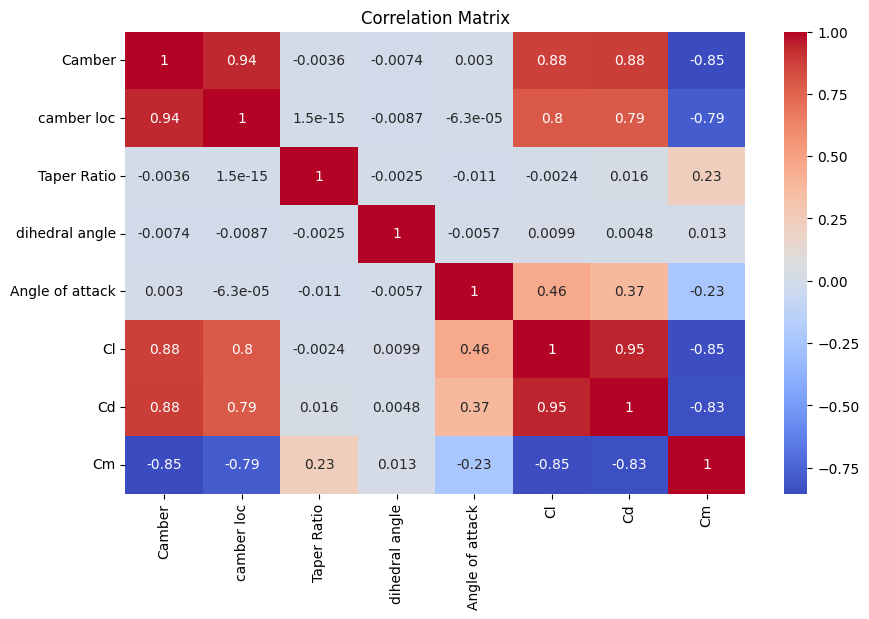


📌 Cl Metrics:
  - MSE:  0.0031
  - RMSE: 0.0561
  - MAE:  0.0432
  - R²:   97.60%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0055
  - MAE:  0.0033
  - R²:   95.47%

📌 Cm Metrics:
  - MSE:  0.0169
  - RMSE: 0.1301
  - MAE:  0.0471
  - R²:   82.38%


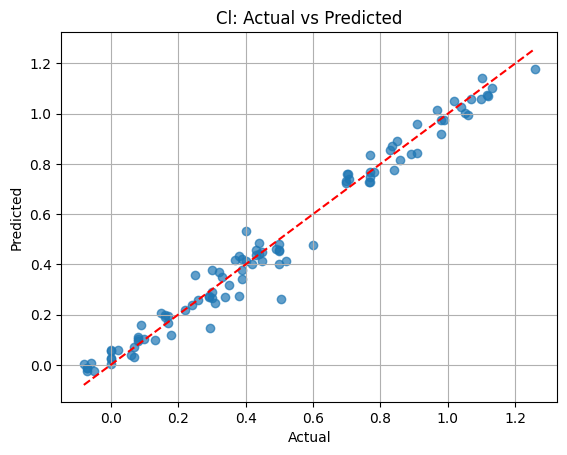

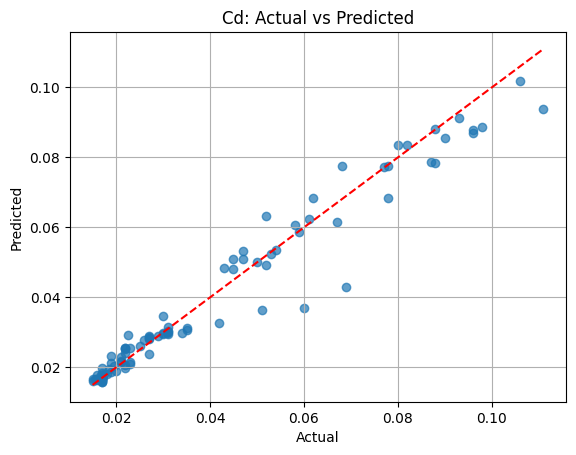

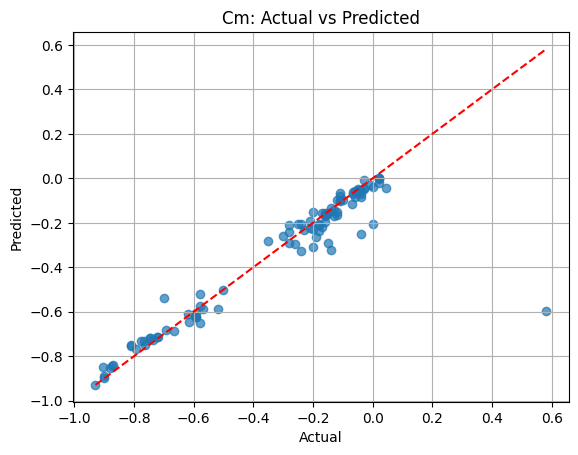


🔮 Prediction for New Wing Design:
Cl: 0.9968
Cd: 0.0400
Cm: -0.6688


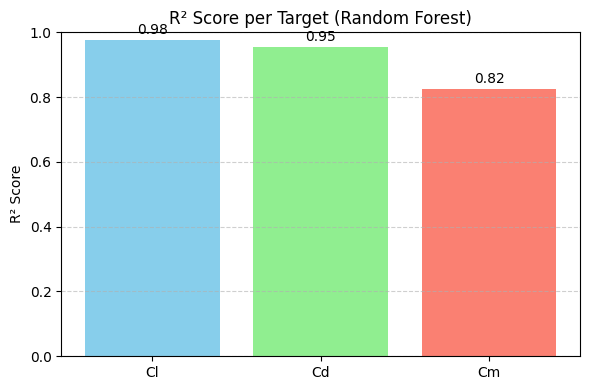

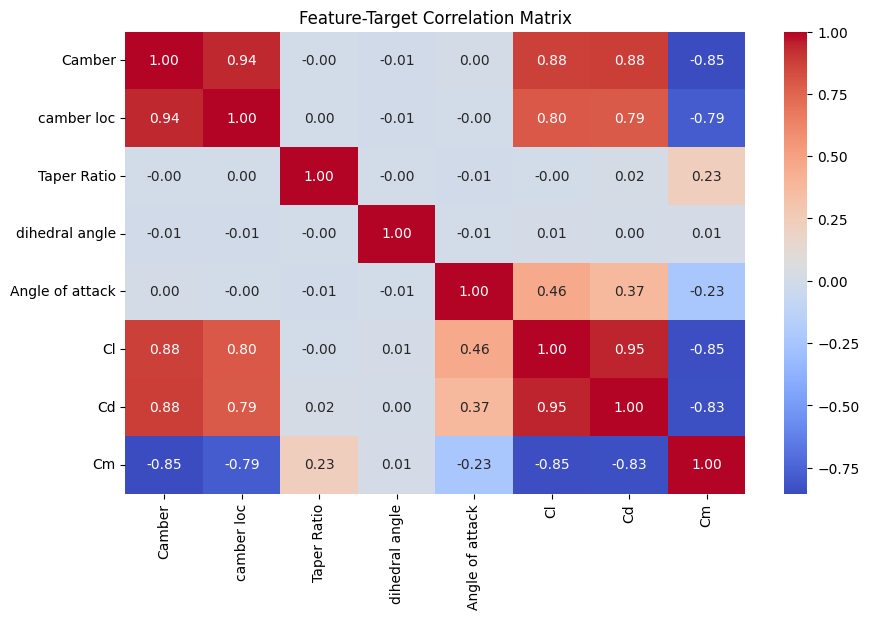

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

from sklearn.ensemble import RandomForestRegressor

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build Random Forest Model ===
def build_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    return model

# === Train Random Forest Models ===
model_cl = build_rf()
model_cd = build_rf()
model_cm = build_rf()

model_cl.fit(X_train_pca, y_cl_train_scaled)
model_cd.fit(X_train_pca, y_cd_train_scaled)
model_cm.fit(X_train_pca, y_cm_train_scaled)

# === Predictions ===
cl_pred_scaled = model_cl.predict(X_test_pca)
cd_pred_scaled = model_cd.predict(X_test_pca)
cm_pred_scaled = model_cm.predict(X_test_pca)

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(model_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(model_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(model_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (Random Forest)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

adaboost

Saving wing.xlsx to wing (9).xlsx


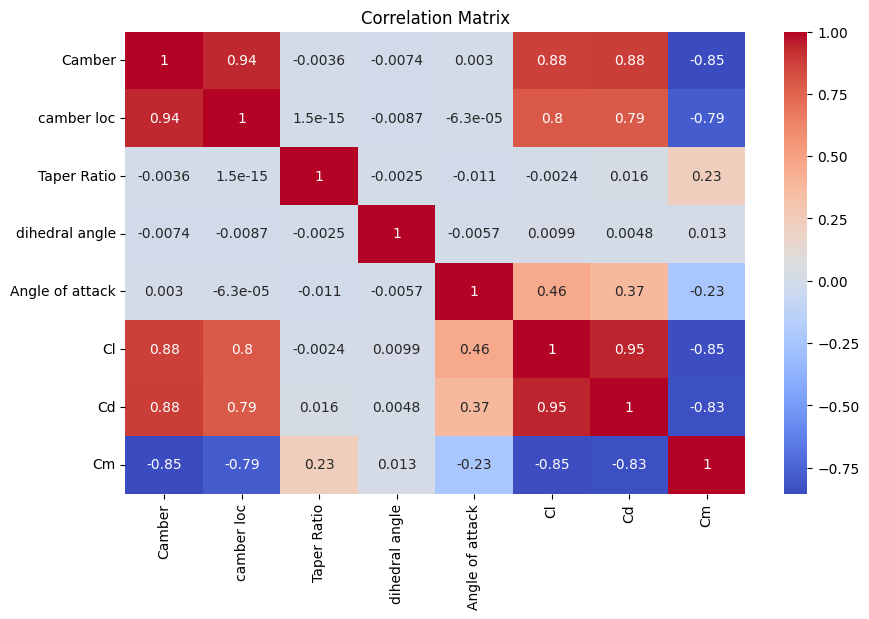


📌 Cl Metrics:
  - MSE:  0.0066
  - RMSE: 0.0814
  - MAE:  0.0661
  - R²:   94.95%

📌 Cd Metrics:
  - MSE:  0.0001
  - RMSE: 0.0072
  - MAE:  0.0057
  - R²:   92.32%

📌 Cm Metrics:
  - MSE:  0.0235
  - RMSE: 0.1534
  - MAE:  0.0863
  - R²:   75.50%


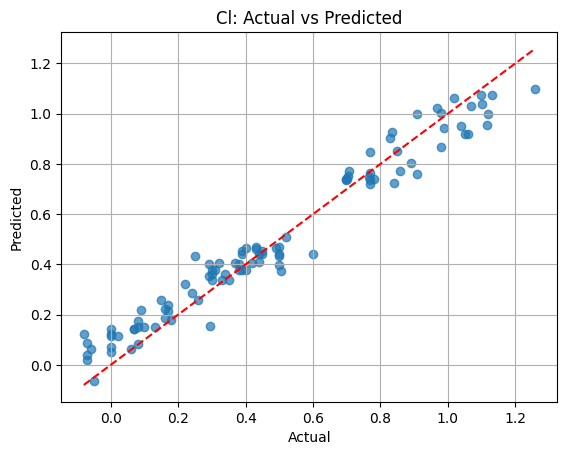

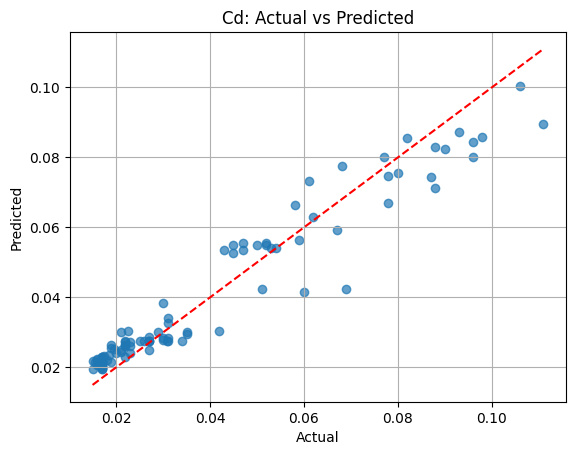

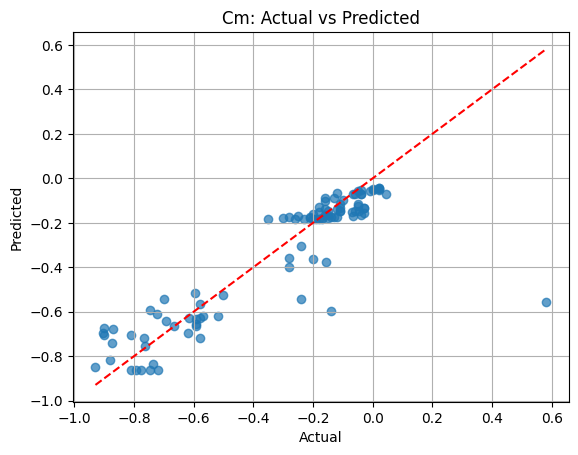


🔮 Prediction for New Wing Design:
Cl: 0.8670
Cd: 0.0385
Cm: -0.6350


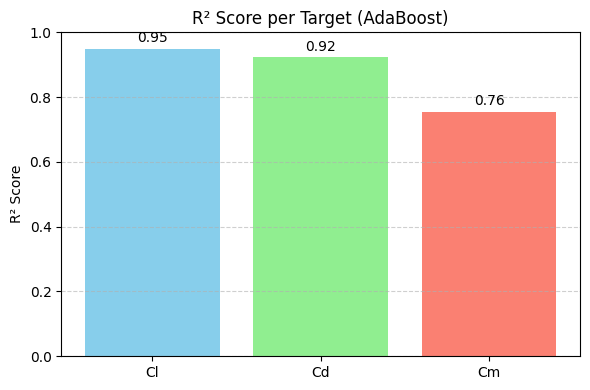

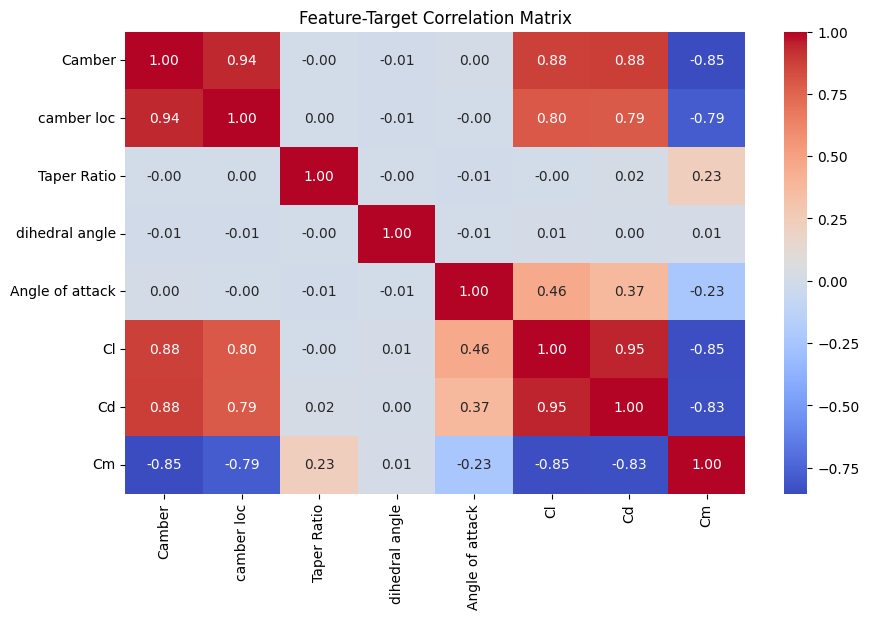

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Build AdaBoost Model ===
def build_adaboost():
    base_model = DecisionTreeRegressor(max_depth=3, random_state=42)
    model = AdaBoostRegressor(base_model, n_estimators=100, random_state=42)
    return model

# === Train AdaBoost Models ===
model_cl = build_adaboost()
model_cd = build_adaboost()
model_cm = build_adaboost()

model_cl.fit(X_train_pca, y_cl_train_scaled)
model_cd.fit(X_train_pca, y_cd_train_scaled)
model_cm.fit(X_train_pca, y_cm_train_scaled)

# === Predictions ===
cl_pred_scaled = model_cl.predict(X_test_pca)
cd_pred_scaled = model_cd.predict(X_test_pca)
cm_pred_scaled = model_cm.predict(X_test_pca)

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)

cl_new = scaler_cl.inverse_transform(model_cl.predict(new_pca).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(model_cd.predict(new_pca).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(model_cm.predict(new_pca).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (AdaBoost)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

CNN

Saving wing.xlsx to wing (11).xlsx


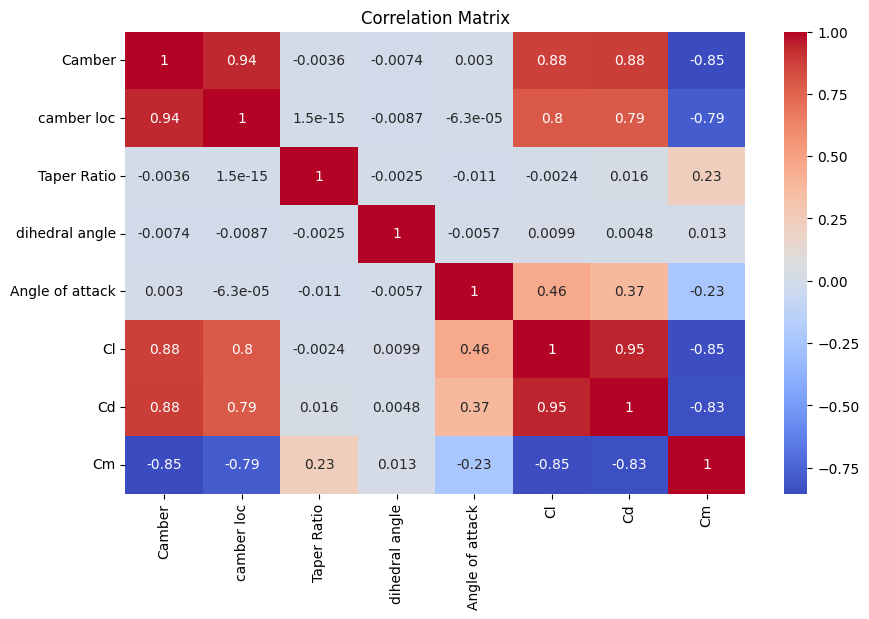

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

📌 Cl Metrics:
  - MSE:  0.0020
  - RMSE: 0.0442
  - MAE:  0.0322
  - R²:   98.51%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0023
  - MAE:  0.0016
  - R²:   99.24%

📌 Cm Metrics:
  - MSE:  0.0157
  - RMSE: 0.1254
  - MAE:  0.0442
  - R²:   83.64%


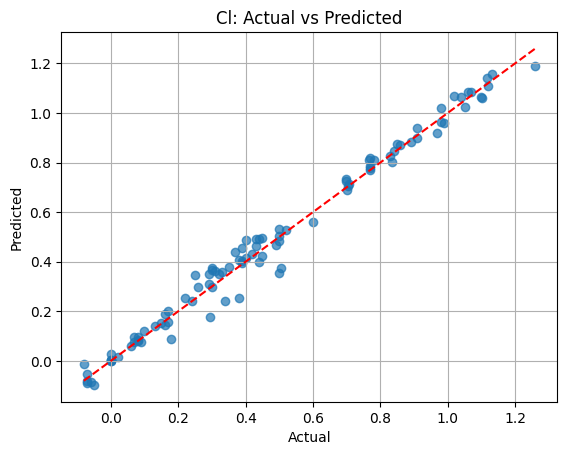

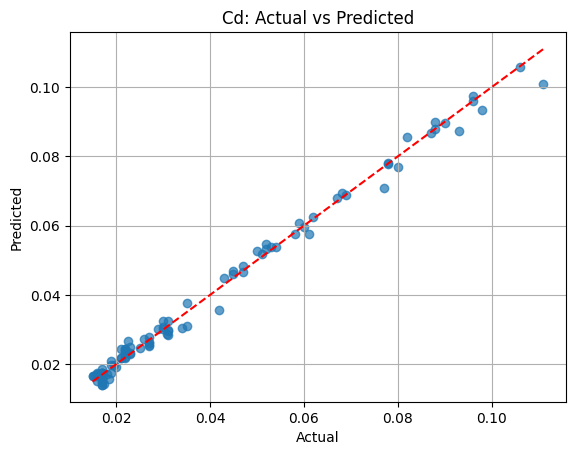

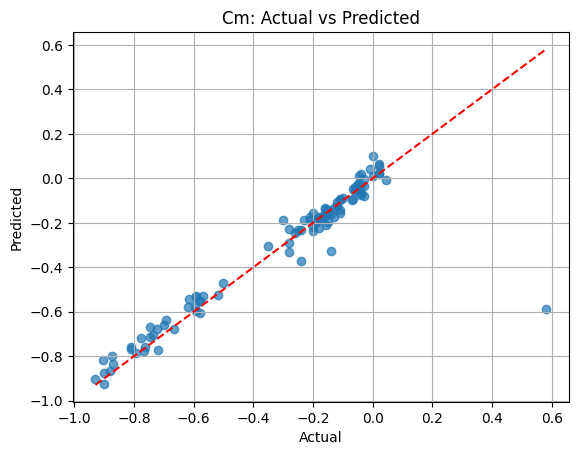

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

🔮 Prediction for New Wing Design:
Cl: 0.9467
Cd: 0.0740
Cm: -0.5710


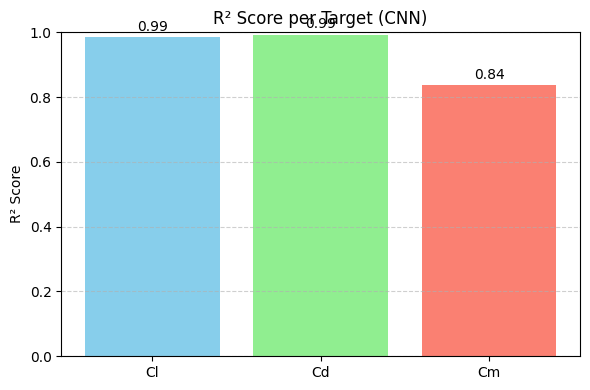

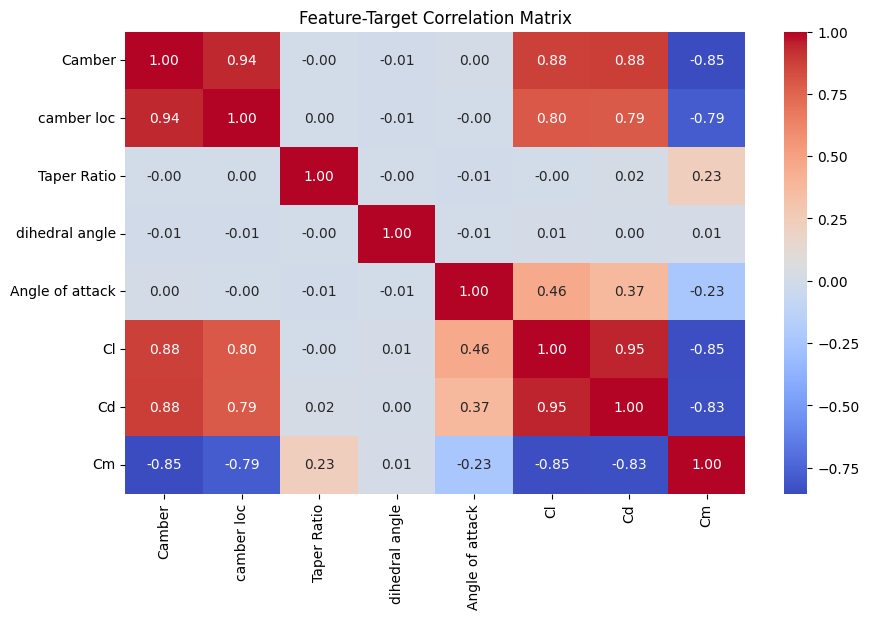

In [ ]:
# === Upload the Excel file ===
from google.colab import files
uploaded = files.upload()

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# === Load and Clean Data ===
df = pd.read_excel("wing.xlsx")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(inplace=True)

# Remove outliers
z = np.abs(zscore(df[["Cl", "Cd", "Cm"]]))
df = df[(z < 3).all(axis=1)]

# === Visualize Correlation ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# === Feature and Target Selection ===
features = ["Camber", "camber loc", "Taper Ratio", "dihedral angle", "Angle of attack"]
targets = ["Cl", "Cd", "Cm"]
X = df[features]
y_cl = df["Cl"]
y_cd = df["Cd"]
y_cm = df["Cm"]

# === Train-Test Split ===
X_train, X_test, y_cl_train, y_cl_test = train_test_split(X, y_cl, test_size=0.2, random_state=42)
_, _, y_cd_train, y_cd_test = train_test_split(X, y_cd, test_size=0.2, random_state=42)
_, _, y_cm_train, y_cm_test = train_test_split(X, y_cm, test_size=0.2, random_state=42)

# === Scaling ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_cl = StandardScaler()
scaler_cd = StandardScaler()
scaler_cm = StandardScaler()

y_cl_train_scaled = scaler_cl.fit_transform(y_cl_train.values.reshape(-1,1)).ravel()
y_cd_train_scaled = scaler_cd.fit_transform(y_cd_train.values.reshape(-1,1)).ravel()
y_cm_train_scaled = scaler_cm.fit_transform(y_cm_train.values.reshape(-1,1)).ravel()

# === PCA ===
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Reshape for CNN ===
X_train_cnn = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# === Build CNN Model ===
def build_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(32, kernel_size=2, activation='relu'),
        Conv1D(64, kernel_size=2, activation='relu'),
        Flatten(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# === Train CNN Models for Cl, Cd, Cm ===
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

def train_model(X_train, y_train):
    model = build_cnn_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=0)
    return model

model_cl = train_model(X_train_cnn, y_cl_train_scaled)
model_cd = train_model(X_train_cnn, y_cd_train_scaled)
model_cm = train_model(X_train_cnn, y_cm_train_scaled)

# === Predictions ===
cl_pred_scaled = model_cl.predict(X_test_cnn).ravel()
cd_pred_scaled = model_cd.predict(X_test_cnn).ravel()
cm_pred_scaled = model_cm.predict(X_test_cnn).ravel()

cl_pred = scaler_cl.inverse_transform(cl_pred_scaled.reshape(-1, 1)).ravel()
cd_pred = scaler_cd.inverse_transform(cd_pred_scaled.reshape(-1, 1)).ravel()
cm_pred = scaler_cm.inverse_transform(cm_pred_scaled.reshape(-1, 1)).ravel()

# === Evaluation ===
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 {label} Metrics:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - R²:   {r2*100:.2f}%")
    return r2

r2_cl = evaluate(y_cl_test, cl_pred, "Cl")
r2_cd = evaluate(y_cd_test, cd_pred, "Cd")
r2_cm = evaluate(y_cm_test, cm_pred, "Cm")

# === Plot Predictions ===
def plot_pred(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title}: Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_pred(y_cl_test, cl_pred, "Cl")
plot_pred(y_cd_test, cd_pred, "Cd")
plot_pred(y_cm_test, cm_pred, "Cm")

# === Prediction for Custom Input ===
custom_input = {
    "Camber": 0.05,
    "camber loc": 0.6,
    "Taper Ratio": 0.7,
    "dihedral angle": 5.0,
    "Angle of attack": 3.0
}

new_df = pd.DataFrame([custom_input])
new_scaled = scaler_X.transform(new_df)
new_pca = pca.transform(new_scaled)
new_cnn_input = new_pca.reshape((new_pca.shape[0], new_pca.shape[1], 1))

cl_new = scaler_cl.inverse_transform(model_cl.predict(new_cnn_input).reshape(-1, 1))[0][0]
cd_new = scaler_cd.inverse_transform(model_cd.predict(new_cnn_input).reshape(-1, 1))[0][0]
cm_new = scaler_cm.inverse_transform(model_cm.predict(new_cnn_input).reshape(-1, 1))[0][0]

print("\n🔮 Prediction for New Wing Design:")
print(f"Cl: {cl_new:.4f}")
print(f"Cd: {cd_new:.4f}")
print(f"Cm: {cm_new:.4f}")

# === R² Bar Chart ===
targets = ["Cl", "Cd", "Cm"]
r2_scores = [r2_cl, r2_cd, r2_cm]

plt.figure(figsize=(6, 4))
bars = plt.bar(targets, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('R² Score per Target (CNN)')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# === Feature-Target Correlation ===
corr = df[features + targets].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature-Target Correlation Matrix")
plt.show()

In [ ]:
import re
import pandas as pd

# Paste your 10 output strings here in this list (you can copy them manually from print outputs)
results = [
    # Add all 10 result strings here, each as a triple-quoted string (""" ... """)
    #ANN
    Cl Metrics:
  - MSE:  0.0022
  - RMSE: 0.0472
  - MAE:  0.0344
  - R²:   98.30%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0051
  - MAE:  0.0037
  - R²:   96.21%

📌 Cm Metrics:
  - MSE:  0.0152
  - RMSE: 0.1233
  - MAE:  0.0447
  - R²:   84.17%

    predicted values

    # DNN
    Cl Metrics:
  - MSE:  0.0023
  - RMSE: 0.0482
  - MAE:  0.0344
  - R²:   98.23%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0032
  - MAE:  0.0025
  - R²:   98.51%

📌 Cm Metrics:
  - MSE:  0.0146
  - RMSE: 0.1207
  - MAE:  0.0367
  - R²:   84.82%

    #Pinn
    Cl Metrics:
  - MSE:  0.0013
  - RMSE: 0.0364
  - MAE:  0.0261
  - R²:   98.99%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0029
  - MAE:  0.0019
  - R²:   98.78%

📌 Cm Metrics:
  - MSE:  0.0156
  - RMSE: 0.1248
  - MAE:  0.0351
  - R²:   83.79%

    #Ann+ga

Cl Metrics:
  - MSE:  0.0096
  - RMSE: 0.0977
  - MAE:  0.0766
  - R²:   92.71%
    Cd Metrics:
  - MSE:  0.0001
  - RMSE: 0.0110
  - MAE:  0.0089
  - R²:   82.05%

    Cm Metrics:
  - MSE:  0.0260
  - RMSE: 0.1612
  - MAE:  0.0900
  - R²:   72.96%

    #mlp
    Cl Metrics:
  - MSE:  0.0015
  - RMSE: 0.0393
  - MAE:  0.0247
  - R²:   98.82%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0030
  - MAE:  0.0021
  - R²:   98.64%

📌 Cm Metrics:
  - MSE:  0.0146
  - RMSE: 0.1208
  - MAE:  0.0314
  - R²:   84.82%

    #cae
    Cl Metrics:
  - MSE:  0.0067
  - RMSE: 0.0818
  - MAE:  0.0661
  - R²:   94.89%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0045
  - MAE:  0.0032
  - R²:   97.06%

📌 Cm Metrics:
  - MSE:  0.0186
  - RMSE: 0.1365
  - MAE:  0.0584
  - R²:   80.61%

    # svr
    Cl Metrics:
  - MSE:  0.0015
  - RMSE: 0.0389
  - MAE:  0.0304
  - R²:   98.84%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0030
  - MAE:  0.0019
  - R²:   98.69%

📌 Cm Metrics:
  - MSE:  0.0142
  - RMSE: 0.1193
  - MAE:  0.0323
  - R²:   85.18%

    # random forest
    Cl Metrics:
  - MSE:  0.0031
  - RMSE: 0.0561
  - MAE:  0.0432
  - R²:   97.60%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0055
  - MAE:  0.0033
  - R²:   95.47%

📌 Cm Metrics:
  - MSE:  0.0169
  - RMSE: 0.1301
  - MAE:  0.0471
  - R²:   82.38%

# random forest
    Cl Metrics:
  - MSE:  0.0066
  - RMSE: 0.0814
  - MAE:  0.0661
  - R²:   94.95%

📌 Cd Metrics:
  - MSE:  0.0001
  - RMSE: 0.0072
  - MAE:  0.0057
  - R²:   92.32%

📌 Cm Metrics:
  - MSE:  0.0235
  - RMSE: 0.1534
  - MAE:  0.0863
  - R²:   75.50%
# cnn
    Cl Metrics:
  - MSE:  0.0020
  - RMSE: 0.0442
  - MAE:  0.0322
  - R²:   98.51%

📌 Cd Metrics:
  - MSE:  0.0000
  - RMSE: 0.0023
  - MAE:  0.0016
  - R²:   99.24%

📌 Cm Metrics:
  - MSE:  0.0157
  - RMSE: 0.1254
  - MAE:  0.0442
  - R²:   83.64%
]

# Extract metrics from each result string
pattern = r"Cl Metrics:\s+- MSE:\s+([\d.]+)\s+- RMSE:\s+([\d.]+)\s+- MAE:\s+([\d.]+)\s+- R²:\s+([\d.]+)%.*?" \
          r"Cd Metrics:\s+- MSE:\s+([\d.]+)\s+- RMSE:\s+([\d.]+)\s+- MAE:\s+([\d.]+)\s+- R²:\s+([\d.]+)%.*?" \
          r"Cm Metrics:\s+- MSE:\s+([\d.]+)\s+- RMSE:\s+([\d.]+)\s+- MAE:\s+([\d.]+)\s+- R²:\s+([\d.]+)%"

model_metrics = []
for i, text in enumerate(results, 1):
    match = re.search(pattern, text, re.DOTALL)
    if match:
        metrics = list(map(float, match.groups()))
        model_metrics.append([i] + metrics)

# Create DataFrame
columns = [
    "Model",
    "Cl_MSE", "Cl_RMSE", "Cl_MAE", "Cl_R2",
    "Cd_MSE", "Cd_RMSE", "Cd_MAE", "Cd_R2",
    "Cm_MSE", "Cm_RMSE", "Cm_MAE", "Cm_R2"
]
df = pd.DataFrame(model_metrics, columns=columns)
print("✅ Model comparison table:")
display(df)

SyntaxError: invalid character '²' (U+00B2) (<ipython-input-1-3a943420a6d3>, line 12)